# How to convert an image to ASCII

## Imports and example image

I will use matplotlib to read image and show progress, numpy to edit image like a 2D array and PIL to finish up and save the new image.

In [1]:
from matplotlib.image import imread
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageDraw, ImageFont

Look at this cat

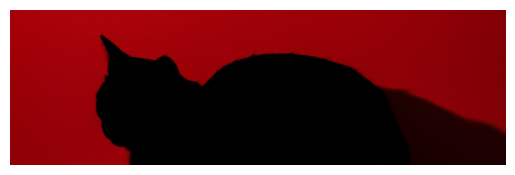

In [2]:
image = imread("cat.jpg")
plt.imshow(image)
plt.axis("off")
plt.show()

## Grayscale
Colored images are not really 2D matricies because each pixel has several values for color: Red, Green and Blue.

We need to convert those 3 color values to a single "Brightness" value which will correspond to our ASCII characters. I also normalize it to (0,1) because it's a bit more intuitive later on


In [3]:
def grayscale(image, gamma=1.4,
              consts={"r": 0.2126, "g": 0.7152, "b": 0.0722}):
    r, g, b = image[:, :, 0], image[:, :, 1], image[:, :, 2]
    grayscale_image = np.matrix(r*consts["r"]**gamma + g * \
        consts["g"]**gamma + b*consts["b"]**gamma, dtype=np.float32)
    return grayscale_image

Now our cat looks like this:

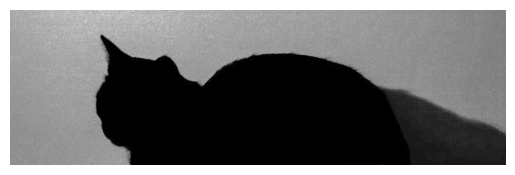

In [4]:
image = grayscale(image)
plt.imshow(image, cmap="gray")
plt.axis("off")
plt.show()

## Downscale

Drawing a character per pixel is too much, considering each character takes several pixels to be readable, so we need to downscale our image and then represent each pixel with character.

This can be done by avaraging the value of a chunk of characters. The size of chunk is equal to some factor by which we downscale

In [5]:
def downscale(image, factor):
    new_size = image.shape[0]//factor, image.shape[1]//factor
    new_image = np.zeros(new_size, dtype=np.float32)
    for i in range(new_size[0]):
        for j in range(new_size[1]):
            new_image[i, j] = image[i * factor : (i + 1) * factor,
                                    j * factor : (j + 1) * factor].mean()
    return new_image

I'll downscal by the factor of 16 because it's very visible

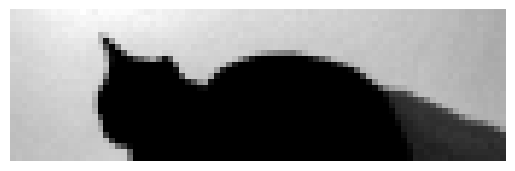

In [6]:
downscaled_image = downscale(image, 16)
plt.imshow(downscaled_image, cmap="gray")
plt.axis("off")
plt.show()

## Converting to ascii
Now we are almost ready to convert this image to ASCII charaters.

I'd like to use "■", "@", "#", "*", "+", "=", "-", ":", ".", " " characters, but

In [7]:
print("Min: ", downscaled_image.min())
print("Max: ", downscaled_image.max())


Min:  0.0
Max:  22.854465


See how the max is definately not an intager and also is to big for our list of ASCII character.

We need to reduce the colors. Which is very straightforward - we multiply each pixel by the amout of characters we got and divide it by max value, to get a number between 0 and our list length, also flooring the value by using "//" so we have nice intagers 

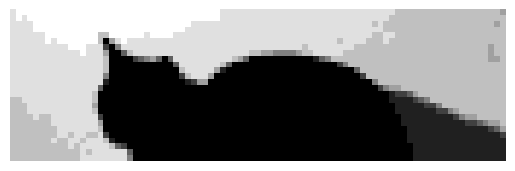

In [8]:
# ascii_chars = ("■", "@", "#", "*", "+", "=", "-", ":", ".", " ")
ascii_chars = (" ", ".", ":", "c", "o", "P","0", "?", "@", "■")
downscaled_image = downscaled_image * (len(ascii_chars)-1) // downscaled_image.max()
plt.imshow(downscaled_image, cmap="gray")
plt.axis("off")
plt.show()

Look at these geese. Ordered, rounderd, moisturized.

In [9]:
print("Uniques: ", np.unique(downscaled_image))

Uniques:  [0. 1. 2. 3. 4. 5. 6. 7. 8.]


Converting each integer to a character we will get a nice array to draw. 

In [10]:
def grayscale_to_ascii(image, ascii_chars):
    ascii_image = np.empty(image.shape, dtype=str)  # Create empty array for ASCII characters

    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            pixel_value = image[i, j]
            ascii_image[i, j] =\
                ascii_chars[int(pixel_value)]  # Assign corresponding ASCII character
    return ascii_image

In [11]:
ascii_array = grayscale_to_ascii(downscaled_image, ascii_chars)
print(ascii_array[:5, :5])  # Print a small part of the ASCII array

[['?' '@' '@' '@' '@']
 ['?' '@' '?' '@' '@']
 ['?' '?' '?' '?' '@']
 ['?' '?' '?' '?' '@']
 ['?' '?' '?' '?' '?']]


And we just draw with pillow (PIL).

In [12]:
def draw_ascii_image(char_matrix, font_path="DejaVuSansMono.ttf", font_size=12, text_color=255, bg_color=0):
    try:
        font = ImageFont.truetype(font_path, font_size)
    except IOError:
        font = ImageFont.load_default()

    # Calculate character size
    bbox = font.getbbox('A')
    char_width = bbox[2] - bbox[0]
    char_height = bbox[3] - bbox[1]

    img_width = char_matrix.shape[1] * char_width
    img_height = char_matrix.shape[0] * char_height

    img = Image.new('L', (img_width, img_height), color=bg_color)
    draw = ImageDraw.Draw(img)

    for y, row in enumerate(char_matrix):
        for x, char in enumerate(row):
            draw.text((x * char_width, y * char_height), str(char), font=font, fill=text_color)

    return img

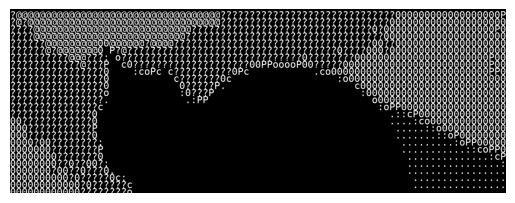

In [13]:
ascii_image = draw_ascii_image(ascii_array, font_size=32)
plt.imshow(ascii_image, cmap="gray")
plt.axis("off")
plt.show()
# ascii_image.show()

## Edge deteciton

Now the more interesting part - edge detection.

There are a couple of methods like differecne of Gaussian or Canny. With mentioned methods conversion of edges to characters would need an aditional detection of direction of the edge using computer vision.

But there is a more convinient method - Sobel operator. 

$$G = \begin{bmatrix}
-1 & 0 & 1 \\
-2 & 0 & 2 \\
-1 & 0 & 1
\end{bmatrix}$$

By applying this operator on the chunk of image we get the difference between left ad right side of the chunk -- the "edgeness" of it.

Did you notice that it only detects the edge on one axis? We can get the top-to-bottom edges too by rotating the operator


In [14]:
def sobel(image):
    Gx = np.array([[-1, 0, 1],
                  [-2, 0, 2],
                  [-1, 0, 1]])
    Gy = np.array([[1, 2, 1],
                  [0, 0, 0],
                  [-1, -2, -1]])
    gradient_x = np.zeros_like(image)
    gradient_y = np.zeros_like(image)
    for i in range(1, image.shape[0] - 1):
        for j in range(1, image.shape[1] - 1):
            region = image[i-1:i+2, j-1:j+2]
            gradient_x[i, j] = np.sum(region * Gx)
            gradient_y[i, j] = np.sum(region * Gy)
    G = (gradient_x, gradient_y)
    return G

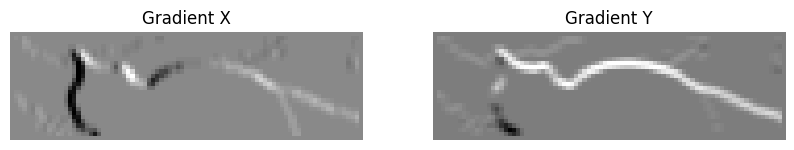

In [15]:
sobel_img = sobel(downscaled_image)

figure, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(sobel_img[0], cmap="gray")
ax[0].set_title("Gradient X")
ax[0].axis("off")
ax[1].imshow(sobel_img[1], cmap="gray")
ax[1].set_title("Gradient Y")
ax[1].axis("off")
plt.show()

Well this doesn't really seem convenient. Now we have two images of two different direction of edges. What do we do with them?

The answer is, of course, math.

<img src="README_files/trigonometry.png" alt="trigonometry drawing" width="400"/>

We can comvine our gradients into one by reffering to triangles and pethagorean theorem.
$$magnitude^2 = G_x^2+G_y^2$$
or, translating
$$magnitude = \sqrt{G_x^2+G_y^2}$$

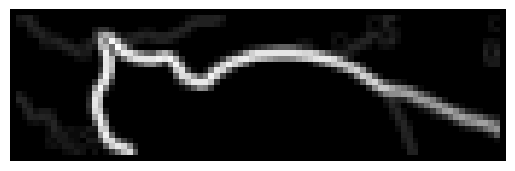

In [16]:
(Gx, Gy) = sobel(downscaled_image)
magnitudes = np.sqrt(Gx**2 + Gy**2)
plt.imshow(magnitudes, cmap="gray")
plt.axis("off")
plt.show()

Now we have some beautiful edges. A bit messy but we can clearly see the subject of the image.

But how do we avoid the task of classifying the angles of those edges using computer vison? Are we not using Sobel just to avoid that?

Well..

It's time for everyone's favorite unlikely alliance -- inverse of tangent...

For those like me who didn't have an unhealthy love for trigonometry let's just say it's some magic function that translates our two edges strengths into a direction.

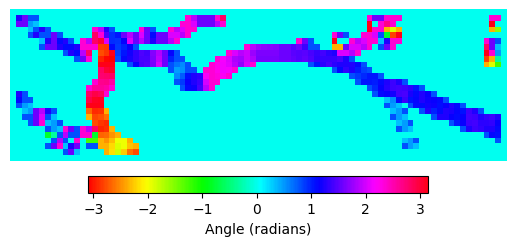

In [17]:
angles = np.arctan2(Gy, Gx)
im = plt.imshow(angles, cmap="hsv")
plt.axis("off")
cbar = plt.colorbar(im, orientation='horizontal', fraction=0.046, pad=0.04)
cbar.set_label('Angle (radians)')
plt.show()

Now each pixel or cell of our 2D array represents a degree (in radians), which we can replace with a special character.

But first let's tidy it up. By thresholding the magnitude we can limit the sensativity of our edge detection.

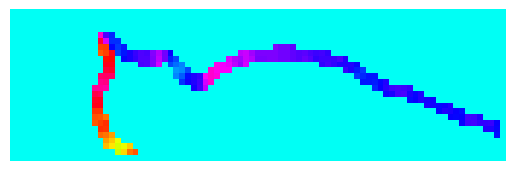

In [18]:
threshold = 0.3
sobel_img = sobel(downscaled_image)

magnitudes = np.sqrt(sobel_img[0]**2 + sobel_img[1]**2)
magnitudes = magnitudes/magnitudes.max()  # Normalize magnitudes

sobel_filtered = np.arctan2(sobel_img[1], sobel_img[0])  # Calculate the angle of the gradient
sobel_filtered[magnitudes < threshold] = 0  # Filter out weak edges

plt.imshow(sobel_filtered, cmap="hsv", vmin=-np.pi, vmax=np.pi)
plt.axis("off")
plt.show()

Let's update our sobel method.

In [19]:
def sobel(image, magnitude_threshhold:float=0):
    assert magnitude_threshhold >= 0 and magnitude_threshhold <= 1
    Gx = np.array([[-1, 0, 1],
                  [-2, 0, 2],
                  [-1, 0, 1]])
    Gy = np.array([[1, 2, 1],
                  [0, 0, 0],
                  [-1, -2, -1]])
    
    gradient_x = np.zeros(image.shape)
    gradient_y = np.zeros(image.shape)
    
    for i in range(1, image.shape[0] - 1):
        for j in range(1, image.shape[1] - 1):
            region = image[i-1:i+2, j-1:j+2]
            gradient_x[i, j] = np.sum(region * Gx)
            gradient_y[i, j] = np.sum(region * Gy)
    
    magnitude = np.sqrt(gradient_x**2 + gradient_y**2)
    magnitude = magnitude/magnitude.max()  # Normalize magnitude
    # filter = magnitude > magnitude_threshhold
    # G = np.zeros(image.shape)
    G = np.arctan2(gradient_x, gradient_y)  # Calculate angle
    G[magnitude < magnitude_threshhold] = None  # Filter out weak edges
    return G

Translating radians to degrees because it's a bit easier to understand

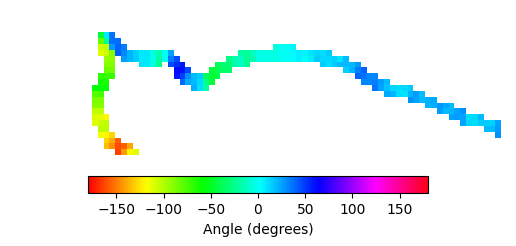

In [20]:
sobel_deg = np.rad2deg(sobel(downscaled_image, magnitude_threshhold=0.3))
im = plt.imshow(sobel_deg, cmap="hsv", vmin=-180, vmax=180)
cbar = plt.colorbar(im, orientation='horizontal', fraction=0.046, pad=0.04)
cbar.set_label('Angle (degrees)')
plt.axis("off")
plt.show()

We can now translate those angles to the right symbol

In [21]:
# Edges in format "Vertical", "Horizontal", "Diagonal1", "Diagonal2"
def generate_edges(degrees_array, cardinal_threshhold, edges = ("|","_","\\","/")):
    edges_array = np.empty(degrees_array.shape, dtype=str)
    for i in range(degrees_array.shape[0]):
        for j in range(degrees_array.shape[1]):
            angle = degrees_array[i, j]
            if np.isnan(angle):
                edges_array[i, j] = " "
            else:
                # Map angle to edge character
                deg = angle % 360
                if deg <= cardinal_threshhold:
                    edges_array[i, j] = edges[1] # _
                elif deg < 90 - cardinal_threshhold:
                    edges_array[i, j] = edges[2] # \
                elif deg <= 90 + cardinal_threshhold:
                    edges_array[i, j] = edges[0] # |
                elif deg < 180 - cardinal_threshhold:
                    edges_array[i, j] = edges[3] # /
                elif deg < 180 + cardinal_threshhold:
                    edges_array[i, j] = edges[1] # _
                elif deg < 270 - cardinal_threshhold:
                    edges_array[i, j] = edges[2] # \
                elif deg < 270 + cardinal_threshhold:
                    edges_array[i, j] = edges[0] # |
                elif deg < 360 - cardinal_threshhold:
                    edges_array[i, j] = edges[3] # /
                else:
                    edges_array[i, j] = edges[1] # _
    return edges_array

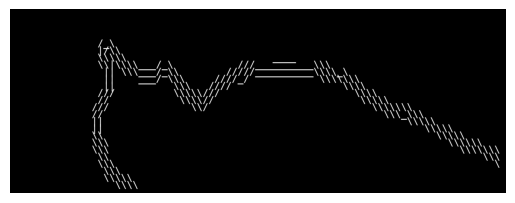

In [22]:
edges_array = generate_edges(sobel_deg, cardinal_threshhold=10)
edges_img = draw_ascii_image(edges_array, font_size=32)
plt.imshow(edges_img, cmap="gray")
plt.axis("off")
plt.show()
# edges_img.show()

Layering our images we get a clearly edged little cat with background

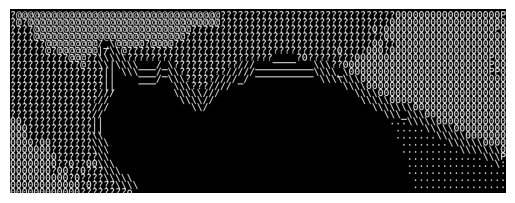

In [23]:
np.copyto(edges_array, ascii_array, where=edges_array == " ")
final_image = draw_ascii_image(edges_array, font_size=32)
plt.imshow(final_image, cmap="gray")
plt.axis("off")
plt.show()
# final_image.save("ascii_art.png")
# final_image.show()


## Afterword

There is a lot of things you can modify here, like making the edges thinner or adding OCR and drawing letters with themselves but I'll stop here _for now_.

It is a very fun project and if you are interested in the topic I highly recommend [this video](https://youtu.be/gg40RWiaHRY) by Acerola of how makes this effect a videogame shader.

Also there's [this Computerphile video](https://youtu.be/uihBwtPIBxM) that explains the Sobel operator better than I do.

See ya.